In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
df1 <- read.csv("/content/CSUSHPINSA.csv")

In [ ]:
df2 <- read.csv("/content/MORTGAGE30US.csv")

In [ ]:
# beginning Jan-1-1987
df2 <- df2 |>
  filter(df2$observation_date >= "1987-01-01")
head(df2)

,observation_date,MORTGAGE30US
,<chr>,<dbl>
1,1987-01-02,9.37
2,1987-01-09,9.32
3,1987-01-16,9.21
4,1987-01-23,9.04
5,1987-01-30,9.08
6,1987-02-06,9.06


# Plot the Home Prices and Average Monthly Mortgage Rate

* a. Home Prices = HPI Index Value*$1,000
* b. Calculate average monthly values for the 30-year mortgage rates. The print is weekly.

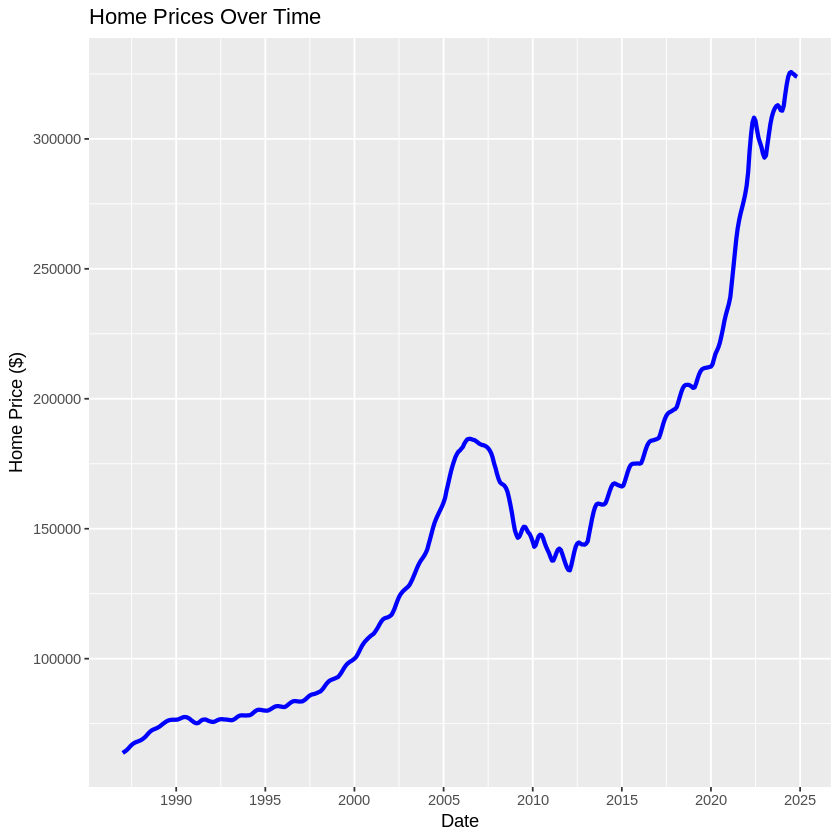

In [ ]:
# a. Home Prices = HPI Index Value*$1,000

# Step 1: Calculate House Price
df1 <- df1 |>
  mutate(observation_date = as.Date(observation_date),
         Home_Price = CSUSHPINSA * 1000)

# Step 2: Plot it
ggplot(df1, aes(x = observation_date, y = Home_Price, group = 1)) +  # group = 1 to avoid grouping issues
  geom_line(color = "blue", linewidth = 1.2) +
  labs(title = "Home Prices Over Time",
       x = "Date",
       y = "Home Price ($)") +
  scale_x_date(date_breaks = "5 years", date_labels = "%Y")  # Set x-axis to 5-year intervals


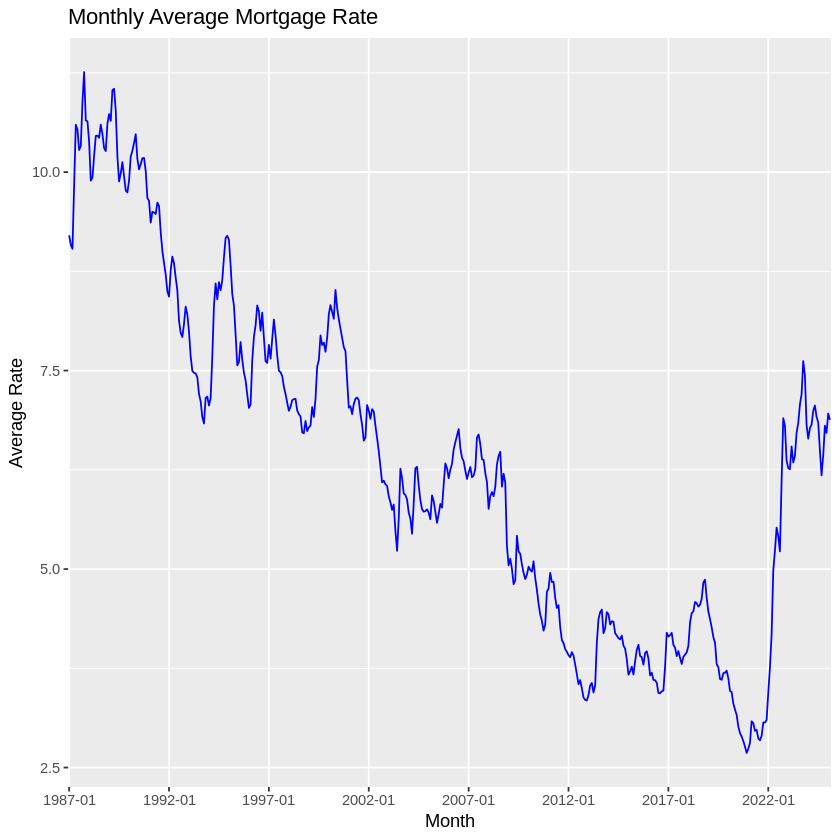

In [ ]:
# b. Calculate average monthly values for the 30-year mortgage rates. The print is weekly.

# Step 1: Calculate Average Monthly Mortgage Rates
tmp <- df2 |>
  mutate(Year = year(observation_date),
         Month = month(observation_date)) |>
  group_by(Year, Month) |>
  summarise(Monthly_Avg_Rate = mean(MORTGAGE30US, na.rm = TRUE), .groups = "drop") |>
  mutate(YearMonth = sprintf("%d-%02d", Year, Month))  # Format YYYY-MM

# Step 2: Plot it
ggplot(tmp, aes(x = as.factor(YearMonth), y = Monthly_Avg_Rate, group = 1)) +
  geom_line(color = "blue") +
  labs(title = "Monthly Average Mortgage Rate",
       x = "Month",
       y = "Average Rate") +
  scale_x_discrete(breaks = tmp$YearMonth[seq(1, nrow(tmp), by = 60)]) # Show every 60th month
# the space is not enough, so i showed every 5 year(60 months) gap on X-axis


# Calculate the assumed monthly rent for the corresponding monthly home price.

* The assumed monthly rent has a gross rental yield of 8.00%.



 * (Gross Rental Yield = Annual Rent/ Home Price)

In [ ]:
df1 <- df1 |>
  mutate(Monthly_Rent = Home_Price * 0.08 / 12)
head(df1)

,observation_date,CSUSHPINSA,Home_Price,Monthly_Rent
,<date>,<dbl>,<dbl>,<dbl>
1,1987-01-01,63.733,63733,424.8867
2,1987-02-01,64.132,64132,427.5467
3,1987-03-01,64.468,64468,429.7867
4,1987-04-01,64.972,64972,433.1467
5,1987-05-01,65.546,65546,436.9733
6,1987-06-01,66.218,66218,441.4533


# Calculate the monthly mortgage payment amounts (P&I) assuming a 30 year mortgage on 90% of the value of the home for every period.

In [ ]:
# create key "YearMonth" for merge 2 datasets
tmp2 <- df1 |>
  mutate(Year = year(observation_date),
         Month = month(observation_date)) |>
  group_by(Year, Month) |>
  mutate(YearMonth = sprintf("%d-%02d", Year, Month))  # Format YYYY-MM

head(tmp2)  # Format YYYY-MM)

observation_date,CSUSHPINSA,Home_Price,Monthly_Rent,Year,Month,YearMonth
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1987-01-01,63.733,63733,424.8867,1987,1,1987-01
1987-02-01,64.132,64132,427.5467,1987,2,1987-02
1987-03-01,64.468,64468,429.7867,1987,3,1987-03
1987-04-01,64.972,64972,433.1467,1987,4,1987-04
1987-05-01,65.546,65546,436.9733,1987,5,1987-05
1987-06-01,66.218,66218,441.4533,1987,6,1987-06


In [ ]:
tmp_merged <- tmp2 |>
  left_join(tmp, by = "YearMonth") |>  # Merge datasets
  select(observation_date, CSUSHPINSA, Home_Price, Monthly_Rent, YearMonth, Monthly_Avg_Rate)  # Keep only relevant columns

# Print first few rows
head(tmp_merged)

observation_date,CSUSHPINSA,Home_Price,Monthly_Rent,YearMonth,Monthly_Avg_Rate
<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1987-01-01,63.733,63733,424.8867,1987-01,9.2040
1987-02-01,64.132,64132,427.5467,1987-02,9.0825
1987-03-01,64.468,64468,429.7867,1987-03,9.0350
1987-04-01,64.972,64972,433.1467,1987-04,9.8325
1987-05-01,65.546,65546,436.9733,1987-05,10.5960
1987-06-01,66.218,66218,441.4533,1987-06,10.5375


In [ ]:
# Compute Monthly Mortgage Payments
tmp_merged <- tmp_merged |>
  mutate(Loan_Amount = Home_Price * 0.90,  # 90% of home price
         Monthly_Interest_Rate = (Monthly_Avg_Rate / 100) / 12,  # Convert annual rate to monthly
         Num_Payments = 30 * 12,  # 30 years * 12 months
         Monthly_Mortgage = (Loan_Amount * Monthly_Interest_Rate) /
                            (1 - (1 + Monthly_Interest_Rate)^(-Num_Payments))) |>
  select(observation_date, CSUSHPINSA, Home_Price, Monthly_Rent, YearMonth, Monthly_Avg_Rate, Monthly_Mortgage)  # Keep relevant columns

head(tmp_merged)

observation_date,CSUSHPINSA,Home_Price,Monthly_Rent,YearMonth,Monthly_Avg_Rate,Monthly_Mortgage
<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1987-01-01,63.733,63733,424.8867,1987-01,9.2040,469.9733
1987-02-01,64.132,64132,427.5467,1987-02,9.0825,467.8489
1987-03-01,64.468,64468,429.7867,1987-03,9.0350,468.3136
1987-04-01,64.972,64972,433.1467,1987-04,9.8325,505.9353
1987-05-01,65.546,65546,436.9733,1987-05,10.5960,543.8560
1987-06-01,66.218,66218,441.4533,1987-06,10.5375,546.8214


# Home ownership also includes certain fixed expenses such as taxes, insurance and HOA fees (if applicable).
* The fixed expense equates to about 1.7% of the value of the home.
* a. Calculate the monthly additional fixed expense burden on home owner.
* b. Calculate the total cost of owning a home.

In [ ]:
# a. Calculate the monthly additional fixed expense burden on home owner.
tmp_merged <- tmp_merged  |>
  mutate(Monthly_Fixed_Expense = Home_Price * 0.017/12)
head(tmp_merged)

observation_date,CSUSHPINSA,Home_Price,Monthly_Rent,YearMonth,Monthly_Avg_Rate,Monthly_Mortgage,Monthly_Fixed_Expense
<date>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1987-01-01,63.733,63733,424.8867,1987-01,9.2040,469.9733,90.28842
1987-02-01,64.132,64132,427.5467,1987-02,9.0825,467.8489,90.85367
1987-03-01,64.468,64468,429.7867,1987-03,9.0350,468.3136,91.32967
1987-04-01,64.972,64972,433.1467,1987-04,9.8325,505.9353,92.04367
1987-05-01,65.546,65546,436.9733,1987-05,10.5960,543.8560,92.85683
1987-06-01,66.218,66218,441.4533,1987-06,10.5375,546.8214,93.80883


In [ ]:
# b. Calculate the total cost of owning a home.
tmp_merged <- tmp_merged  |>
  mutate(Total_Cost_Own = Monthly_Mortgage + Monthly_Fixed_Expense) |>
  select(observation_date, Home_Price, Monthly_Rent, YearMonth, Monthly_Avg_Rate, Monthly_Mortgage,Monthly_Fixed_Expense,Total_Cost_Own)
head(tmp_merged)

observation_date,Home_Price,Monthly_Rent,YearMonth,Monthly_Avg_Rate,Monthly_Mortgage,Monthly_Fixed_Expense,Total_Cost_Own
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1987-01-01,63733,424.8867,1987-01,9.2040,469.9733,90.28842,560.2617
1987-02-01,64132,427.5467,1987-02,9.0825,467.8489,90.85367,558.7025
1987-03-01,64468,429.7867,1987-03,9.0350,468.3136,91.32967,559.6433
1987-04-01,64972,433.1467,1987-04,9.8325,505.9353,92.04367,597.9790
1987-05-01,65546,436.9733,1987-05,10.5960,543.8560,92.85683,636.7128
1987-06-01,66218,441.4533,1987-06,10.5375,546.8214,93.80883,640.6302


# Compare in which periods it is cheaper to own a home vs renting a home?

In [ ]:
tmp_merged <- tmp_merged  |>
  mutate(Own_Rent_Diff = Total_Cost_Own - Monthly_Rent,
        Own_VS_Rent = ifelse(Own_Rent_Diff < 0,"Own","Rent")) |>
  select(observation_date, Home_Price, Monthly_Rent, Monthly_Avg_Rate, Monthly_Mortgage,Monthly_Fixed_Expense,Total_Cost_Own,Own_VS_Rent)
head(tmp_merged)

observation_date,Home_Price,Monthly_Rent,Monthly_Avg_Rate,Monthly_Mortgage,Monthly_Fixed_Expense,Total_Cost_Own,Own_VS_Rent
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1987-01-01,63733,424.8867,9.2040,469.9733,90.28842,560.2617,Rent
1987-02-01,64132,427.5467,9.0825,467.8489,90.85367,558.7025,Rent
1987-03-01,64468,429.7867,9.0350,468.3136,91.32967,559.6433,Rent
1987-04-01,64972,433.1467,9.8325,505.9353,92.04367,597.9790,Rent
1987-05-01,65546,436.9733,10.5960,543.8560,92.85683,636.7128,Rent
1987-06-01,66218,441.4533,10.5375,546.8214,93.80883,640.6302,Rent


In [ ]:
# Identify periods where renting or owning is better
tmp_periods <- tmp_merged |>
  mutate(Period_Change = lag(Own_VS_Rent, default = first(Own_VS_Rent)) != Own_VS_Rent) |>  # Detect changes
  mutate(Period_ID = cumsum(Period_Change)) |>  # Create period ID for consecutive blocks
  group_by(Period_ID, Own_VS_Rent) |>  # Group by period and Rent/Own status
  summarise(Start_Date = min(observation_date),
            End_Date = max(observation_date),
            Duration_Months = n(),
            .groups = "drop") |>  # Keep only essential groupings
  arrange(Start_Date)  # Sort by time

# Print result
print(tmp_periods)

# A tibble: 15 × 5
   Period_ID Own_VS_Rent Start_Date End_Date   Duration_Months
       <int> <chr>       <date>     <date>               <int>
 1         0 Rent        1987-01-01 2003-02-01             194
 2         1 Own         2003-03-01 2003-03-01               1
 3         2 Rent        2003-04-01 2003-04-01               1
 4         3 Own         2003-05-01 2003-07-01               3
 5         4 Rent        2003-08-01 2003-12-01               5
 6         5 Own         2004-01-01 2004-03-01               3
 7         6 Rent        2004-04-01 2004-09-01               6
 8         7 Own         2004-10-01 2004-11-01               2
 9         8 Rent        2004-12-01 2004-12-01               1
10         9 Own         2005-01-01 2005-02-01               2
11        10 Rent        2005-03-01 2005-04-01               2
12        11 Own         2005-05-01 2005-07-01               3
13        12 Rent        2005-08-01 2008-11-01              40
14        13 Own         2008-12-01 

In [ ]:
# Save the data frame as a CSV file
write.csv(tmp_periods, "rent_own_periods.csv", row.names = FALSE)

# Write down your conclusions and observations.

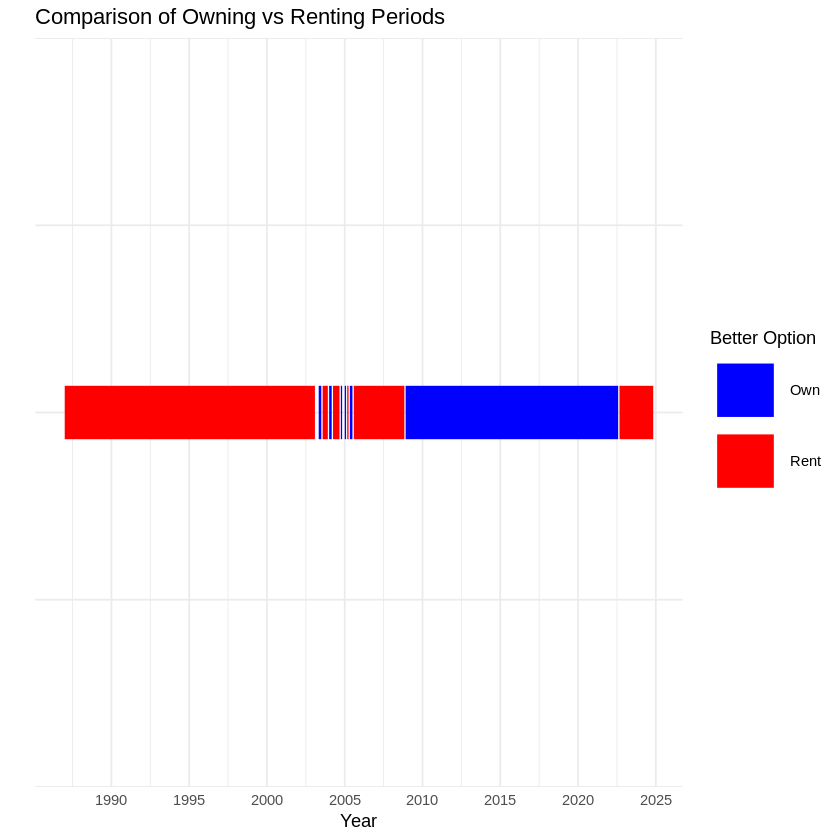

In [ ]:
# Plot Rent vs Own periods with enhanced aesthetics
ggplot(tmp_periods, aes(x = Start_Date, xend = End_Date, y = 1, yend = 1, color = Own_VS_Rent)) +
  geom_segment(size = 15) +  # Thicker bars for better visibility
  scale_color_manual(values = c("Own" = "blue", "Rent" = "red")) +  # Assign colors
  labs(title = "Comparison of Owning vs Renting Periods",
       x = "Year",
       y = "",
       color = "Better Option") +
  theme_minimal() +
  theme(axis.text.y = element_blank(),  # Remove y-axis labels for clarity
        axis.ticks.y = element_blank(),  # Remove y-axis ticks
        panel.grid.minor.y = element_blank()) +
  scale_x_date(date_labels = "%Y", date_breaks = "5 years")  # Format x-axis with year labels


# Conclusions and Observations on Home Ownership vs Renting
**1. Long Periods of Renting Before 2003**
* Renting was the preferred or more affordable option from 1987 to early 2003 (194 months, or over 16 years).
* This suggests that home prices or mortgage rates were high relative to rent during this period, making home ownership less attractive.

**2. Frequent Switching Between Rent and Own (2003 - 2008)**
* From March 2003 to November 2008, frequent short periods of owning and renting (1 to 6 months per period).
* This suggests a volatile market where home ownership became attractive for short bursts but was not sustained.
* This could be due to interest rate fluctuations, housing market instability, or external economic conditions.

**3. A Long Period Favoring Home Ownership (2008 - 2022)**
* From December 2008 to August 2022 (165 months, or ~14 years), owning a home was more favorable.
* This period includes the aftermath of the 2008 financial crisis, when mortgage rates fell significantly due to government interventions and policies promoting homeownership.
* Low interest rates and home price stability likely made owning a home the better financial decision.

**4. Recent Shift Back to Renting (2022 - Present)**
* Since September 2022 (27 months so far), renting has become more attractive again.
* This aligns with recent trends of rising mortgage interest rates (due to inflation control policies).
* Higher borrowing costs and expensive home prices could be the main reasons why renting is currently a better financial option.



# Key Takeaways
* Periods of long-term renting (1987-2003, 2022-present) suggest times when homeownership was either too expensive or financially unfavorable.
* Frequent transitions between renting and owning (2003-2008) indicate a volatile housing market where no single option was dominant.
* The longest period favoring homeownership (2008-2022) aligns with historically low mortgage rates after the financial crisis.
* The recent trend (2022 onwards) favoring renting suggests that rising mortgage rates are making homeownership less affordable.